In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
sns.set()

In [37]:
# Đọc dữ liệu 
test = pd.read_csv("Data/test.csv")
train = pd.read_csv("Data/train.csv")
test_ids = test['PassengerId'].values # Dùng để so sánh với submission
# Kết hợp 2 (test va train) để tiền xử lý dễ dàng hơn và đồng bộ hơn
train['train'] = 1
test['train'] = 0
data=train.append(test,sort=False)
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1


In [3]:
# Keeping useful features
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
data = data[features + ['Survived'] + ['train']]
data

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train
0,22.0,S,7.2500,0,3,male,1,0.0,1
1,38.0,C,71.2833,0,1,female,1,1.0,1
2,26.0,S,7.9250,0,3,female,0,1.0,1
3,35.0,S,53.1000,0,1,female,1,1.0,1
4,35.0,S,8.0500,0,3,male,0,0.0,1
...,...,...,...,...,...,...,...,...,...
413,NaN,S,8.0500,0,3,male,0,NaN,0
414,39.0,C,108.9000,0,1,female,0,NaN,0
415,38.5,S,7.2500,0,3,male,0,NaN,0
416,NaN,S,8.0500,0,3,male,0,NaN,0


In [4]:
# Categorical values need to be transformed into numeric.
data['Sex'] = data['Sex'].replace(["female", "male"], [0, 1])
data['Embarked'] = train['Embarked'].replace(['S', 'C', 'Q'], [1, 2, 3])

In [5]:
# Split data into train and test.
train = data.query('train == 1')
test = data.query('train == 0')

In [6]:
# Drop missing values from the train set.
train.dropna(axis=0, inplace=True)
labels = train['Survived'].values

c:\users\kiet\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


As we saw Naive Bayes models expect the features to be independent, so let's apply the Pearson correlation coefficient on them to give us a hint about how independent they are from the others.

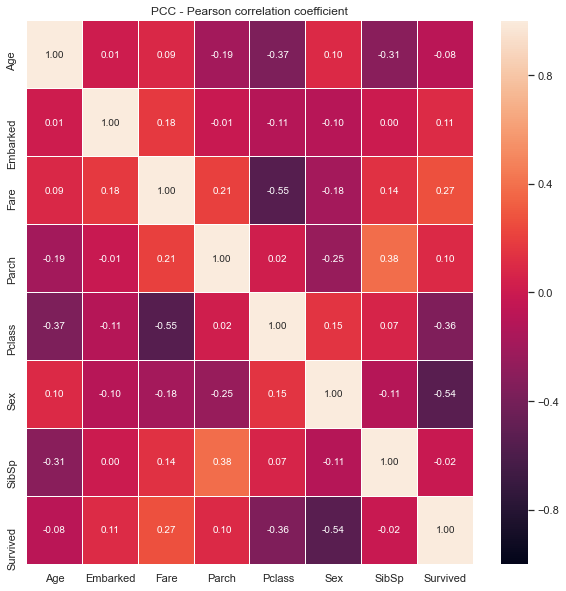

In [7]:
columns = train[features+['Survived']].columns.tolist()
nColumns = len(columns)
result = pd.DataFrame(np.zeros((nColumns, nColumns)), columns=columns)
for col_a in range(nColumns):
    for col_b in range(nColumns):
        result.iloc[[col_a], [col_b]] = scipy.stats.pearsonr(train.loc[:,columns[col_a]],train.loc[:,columns[col_b]])[0]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(result, yticklabels=columns, vmin=-1, vmax=1,annot=True, fmt='.2f', linewidths=.1)
ax.set_title('PCC - Pearson correlation coefficient')
plt.show()

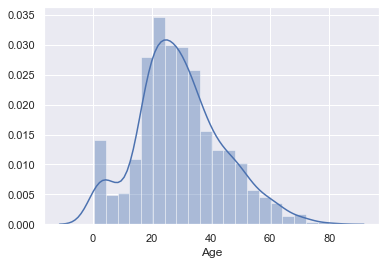

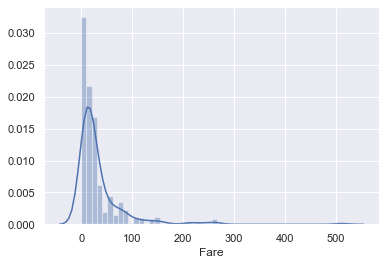

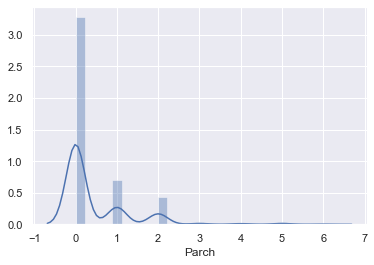

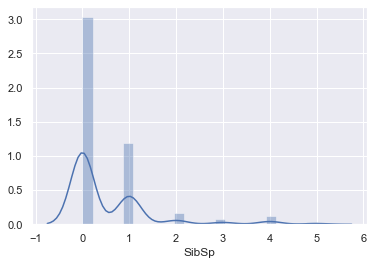

In [8]:
continuous_numeric_features = ['Age', 'Fare', 'Parch', 'SibSp']
for feature in continuous_numeric_features:
    sns.distplot(train[feature])
    plt.show()

In [11]:
test.head(5)

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train
0,34.5,1.0,7.8292,0,3,1,0,NaN,0
1,47.0,2.0,7.0000,0,3,0,1,NaN,0
2,62.0,1.0,9.6875,0,2,1,0,NaN,0
3,27.0,1.0,8.6625,0,3,1,0,NaN,0
4,22.0,1.0,12.2875,1,3,0,1,NaN,0


In [13]:
test.drop(['train', 'Survived', 'Pclass'], axis=1, inplace=True)

In [17]:
train.head(5),test.head(5)

(    Age  Embarked     Fare  Parch  Sex  SibSp
 0  22.0       1.0   7.2500      0    1      1
 1  38.0       2.0  71.2833      0    0      1
 2  26.0       1.0   7.9250      0    0      0
 3  35.0       1.0  53.1000      0    0      1
 4  35.0       1.0   8.0500      0    1      0,
     Age  Embarked     Fare  Parch  Sex  SibSp
 0  34.5       1.0   7.8292      0    1      0
 1  47.0       2.0   7.0000      0    0      1
 2  62.0       1.0   9.6875      0    1      0
 3  27.0       1.0   8.6625      0    1      0
 4  22.0       1.0  12.2875      1    0      1)

In [18]:
classifier = GaussianNB()
classifier.fit(train,labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [22]:
# Unfortunately sklearn naive Bayes algorithm currently do not make inference with missing data (but should do), 
# so we need to input missing data.
test.fillna(test.mean(), inplace=True)
test_predictions = classifier.predict(test)

c:\users\kiet\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [47]:
y_pre = pd.DataFrame({'PassengerId': test_ids})
y_pre['Survived'] = test_predictions.astype('int')
print(y_pre)
print(submission)

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [40]:
submission = pd.read_csv('submission.csv')
y_test = submission['Survived'].values
print("Accuracy:",metrics.accuracy_score(y_test, test_predictions))

Accuracy: 1.0
